In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pylab as plt

In [3]:
from image_analysis.read_files import *
from image_analysis.fit import plot, statistics
from image_analysis.fit import regionprops
from image_analysis.preprocess import mask

In [4]:
df = pd.read_excel("results_from_image_analysis_figure_4.xlsx")
df.loc[df['Animal size, cm'] == 'development', 'Animal size, cm'] = 1.5
df.loc[df['Exact animal size (snout to tail), cm'] == 'development', 'Exact animal size (snout to tail), cm'] = 1.5

In [5]:
df.head()

,Sample name,HCR,"Animal size, cm","Regeneration time, dpa","Exact animal size (snout to tail), cm","Blastema width, um","x0(Shh), um","x0(Fgf8), um","Volume^1/3(Shh), um","Volume^1/3(Fgf8), um","Volume^1/3(Dusp), um"
0,hcr11_lb27_fl,11,1.5,development,1.5,284,42,66,56.082362,96.264030,96.367228
1,hcr11_lb28_fl,11,1.5,development,1.5,300,52,88,50.523565,118.366951,76.702625
2,hcr15_lb41_fl,15,1.5,development,1.5,250,28,64,52.053200,102.600583,143.503563
3,hcr16_lb44_fl,16,1.5,development,1.5,240,50,70,57.340123,118.235668,114.030360
4,hcr16_lb45_fl,16,1.5,development,1.5,256,48,74,51.700447,101.728098,125.571400


# Plot 

In [6]:
from matplotlib_defaults import *

# smaller fonts
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10

# Set axis ticks
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

In [7]:
colormap = plt.colormaps['Dark2']
colors = colormap(np.linspace(0, 1, 10))
sizes = df['Animal size, cm'].unique()
size_to_color = {
    sizes[0]: colors[1], 
    sizes[1]: colors[2],
    sizes[2]: colors[3],
    sizes[3]: colors[4]
}

df['color'] = df['Animal size, cm'].map(size_to_color)

# Define the marker mapping
default_marker = 'o'  # Circle marker
# Star marker for HCR = 23, another method for dusp staning
df['marker'] = df['HCR'].apply(lambda x: '*' if x == 23 else default_marker)

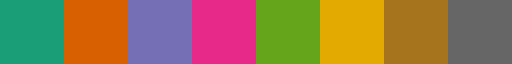

In [8]:
colormap

In [9]:
df.head()

,Sample name,HCR,"Animal size, cm","Regeneration time, dpa","Exact animal size (snout to tail), cm","Blastema width, um","x0(Shh), um","x0(Fgf8), um","Volume^1/3(Shh), um","Volume^1/3(Fgf8), um","Volume^1/3(Dusp), um",color,marker
0,hcr11_lb27_fl,11,1.5,development,1.5,284,42,66,56.082362,96.264030,96.367228,"[0.10588235294117647, 0.6196078431372549, 0.46...",o
1,hcr11_lb28_fl,11,1.5,development,1.5,300,52,88,50.523565,118.366951,76.702625,"[0.10588235294117647, 0.6196078431372549, 0.46...",o
2,hcr15_lb41_fl,15,1.5,development,1.5,250,28,64,52.053200,102.600583,143.503563,"[0.10588235294117647, 0.6196078431372549, 0.46...",o
3,hcr16_lb44_fl,16,1.5,development,1.5,240,50,70,57.340123,118.235668,114.030360,"[0.10588235294117647, 0.6196078431372549, 0.46...",o
4,hcr16_lb45_fl,16,1.5,development,1.5,256,48,74,51.700447,101.728098,125.571400,"[0.10588235294117647, 0.6196078431372549, 0.46...",o


# Remove another method for Dusp

In [10]:
df.loc[df['HCR'] == 23, df.columns[df.columns.str.contains('dusp')]] = pd.NA

# Dynamic ~ L_blastema vs. static ~ L_Animal size, cm scaling

In [11]:
df.sort_values(by=['Blastema width, um'], inplace=True)
df_vs_animal_size = df
df_vs_animal_size.sort_values(by=['Exact animal size (snout to tail), cm'], inplace=True)

In [12]:
columns_to_plot = [
    'Volume^1/3(Shh), um', 
    'Volume^1/3(Fgf8), um', 
    'x0(Shh), um', 
    'x0(Fgf8), um', 
    'Volume^1/3(Dusp), um', 
]

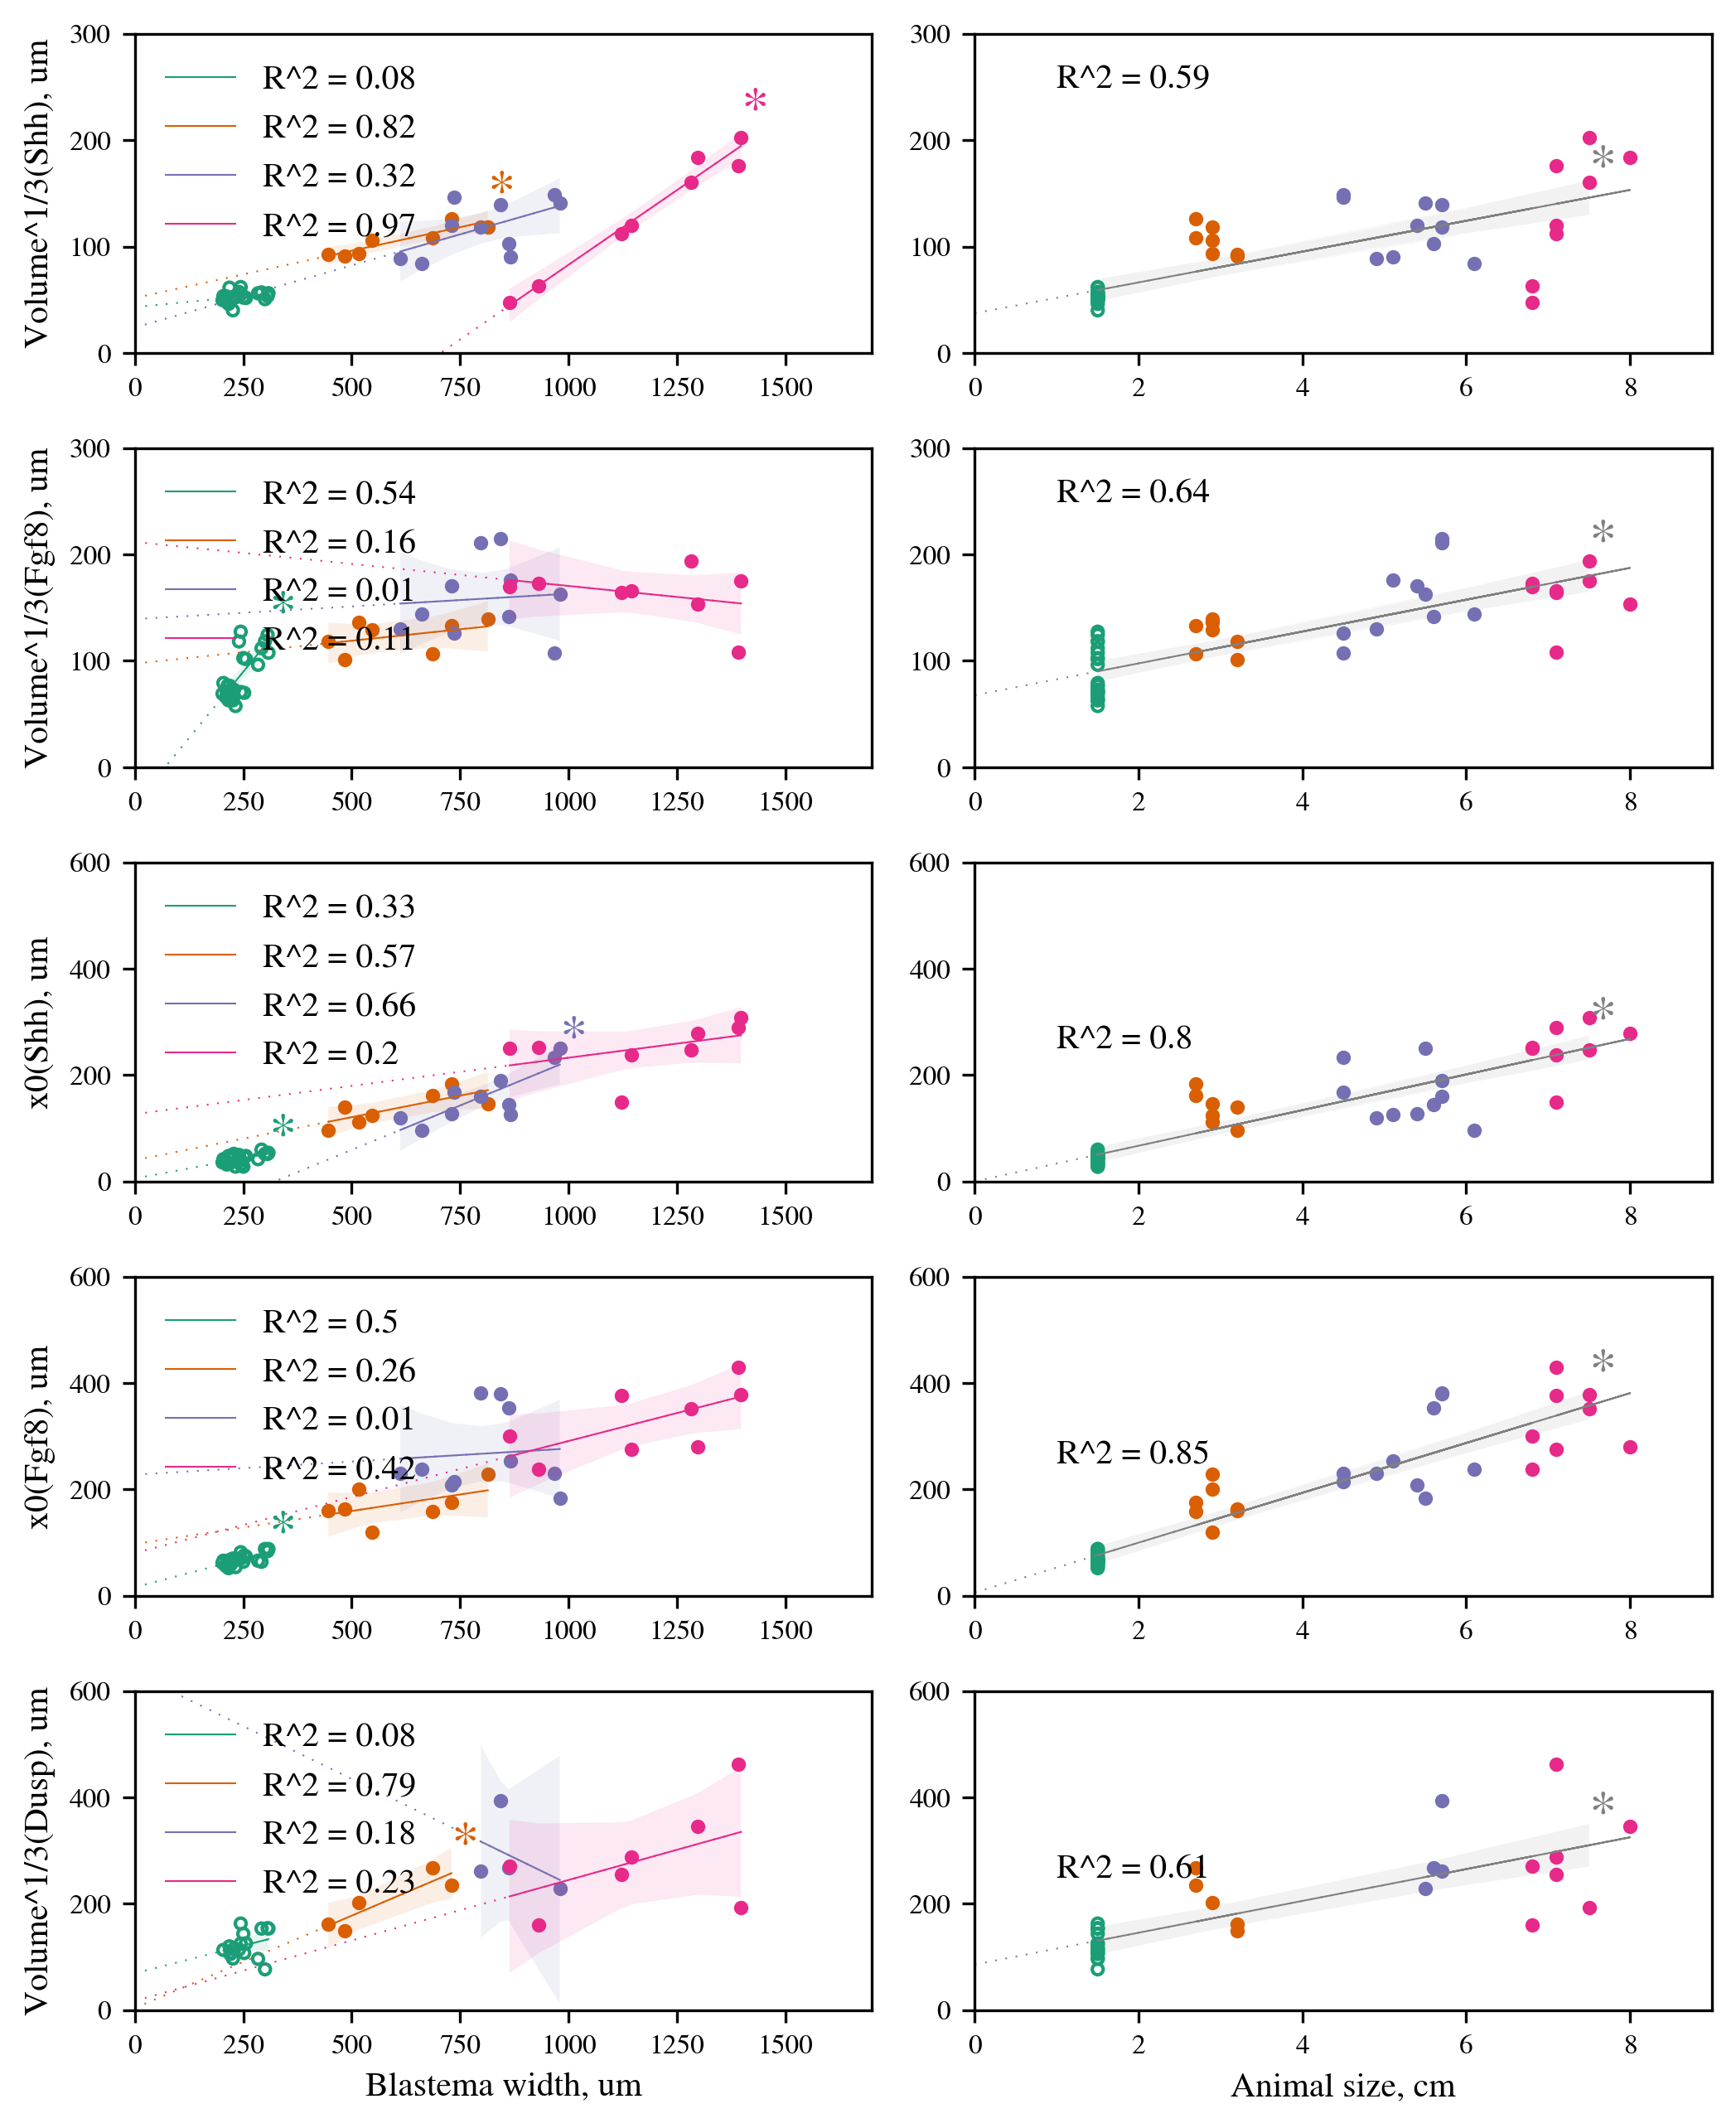

In [13]:
nrows, ncols = len(columns_to_plot), 2
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]), sharex=False, sharey=False)

df.sort_values(by=['Blastema width, um'], inplace=True)

for i, to_plot in enumerate( columns_to_plot ): 
    for j in [0, 1]:
        ######### 1st column #########
        if j == 0: 
            """
            #df_regr = df[df['Animal size, cm'] != 1.5]
            x, y = np.array(df['Blastema width, um']), np.array(df[to_plot]) # um
            x, y = x[~np.isnan(y)].astype(float), y[~np.isnan(y)].astype(float)  # Remove NaNs
            x, y = x[~np.isnan(x)], y[~np.isnan(x)]  # Remove NaNs

            # regression through all
            _, _, _, r2 = plot.add_regr(ax[i, j], x, y, 'gray', '', fit_intercept=True, extend_to_zero=True)
            """
            for size in sizes:
                df_regr = df[df['Animal size, cm'] == size]
                    
                x, y = np.array(df_regr['Blastema width, um']), np.array(df_regr[to_plot]) # um
                x, y = x[~np.isnan(y)].astype(float), y[~np.isnan(y)].astype(float)  # Remove NaNs
                x, y = x[~np.isnan(x)], y[~np.isnan(x)]  # Remove NaNs
                
                _, _, _, r2 = plot.add_regr(ax[i, j], x, y, size_to_color[size], '', fit_intercept=True, extend_to_zero=True)
            
                if size != 1.5:
                    ax[i, j].scatter(
                        x, y,
                        edgecolor=size_to_color[size], facecolor=size_to_color[size],
                        s=10
                    )
                else: # plot limb buds as empty dots
                    ax[i, j].scatter(
                        x, y,
                        edgecolor=size_to_color[size], facecolor='none',
                        s=10
                    )

                ax[i, j].set_ylabel( to_plot )
                ax[i, j].legend()
    
                if ('Dusp' in to_plot) or ('x0' in to_plot)  or ('length_L_SF' in to_plot):
                    ax[i, j].set_ylim(0, 600)
                else:
                    ax[i, j].set_ylim(0, 300)
    
                ax[i, j].set_xlim(0, 1700)
        
        ######### 2nd column #########
        else:
            #df_regr = df[df['Animal size, cm'] != 1.5]
            x, y = np.array(df_vs_animal_size['Exact animal size (snout to tail), cm']).astype(float), np.array(df_vs_animal_size[to_plot]) # um
            x, y = x[~np.isnan(y)].astype(float), y[~np.isnan(y)].astype(float)  # Remove NaNs
            x, y = x[~np.isnan(x)], y[~np.isnan(x)]  # Remove NaNs

            # regression y = k * L_Animal size, cm + b                    
            k, b, y_est, y_err, k_err, b_err, r2 = statistics.regr(x, y, fit_intercept=True, return_r2=True)

            _, _, _, r2 = plot.add_regr(ax[i, j], x, y, 'gray', '', fit_intercept=True, extend_to_zero=True)

            
            ax[i, j].text(
                1, 250,
                f'R^2 = {round( r2, 2)}'
            )
            

            for size in sizes:
                df_regr = df_vs_animal_size[df_vs_animal_size['Animal size, cm'] == size]
            
                x = np.array(df_regr['Exact animal size (snout to tail), cm']).astype(float)
                y = np.array(df_regr[to_plot]) # um
                    
                x, y = x[~np.isnan(y)], y[~np.isnan(y)]
                x, y = x[~np.isnan(x)], y[~np.isnan(x)]
                                      
                if size != 1.5:
                    ax[i, j].scatter(
                        x, y,
                        edgecolor=size_to_color[size], facecolor=size_to_color[size],
                        s=10,
                    )
    
                else:
                    ax[i, j].scatter(
                        x, y,
                        edgecolor=size_to_color[size], facecolor='none',
                        s=10
                    )

            
            if ('Dusp' in to_plot) or ('x0' in to_plot)  or ('length_L_SF' in to_plot):
                ax[i, j].set_ylim(0, 600)
            else:
                ax[i, j].set_ylim(0, 300)
                
            ax[i, j].set_xlim(0, 9)
            

ax[4, 0].set_xlabel( 'Blastema width, um' )
ax[4, 1].set_xlabel( 'Animal size, cm' )
plt.savefig(f'fig/figure_s7.pdf')
#plt.savefig(f'final/Lsf_pc{pc}_Lbl_vs_Lanimal.pdf')
plt.tight_layout()
plt.show()